## MS-SMC' examine bias from approximation

This notebook investigates a potential bias in topology-change waiting distance estimation that can arise from intervening tree-change events. To investigate this we perform two analyses under a range of species tree scenarios. We ask how different the P(topology-change | S,G) is between two genealogies on either side of a tree-change event. We also ask how different this is between two trees at the beginning versus end of a waiting distance interval.


In [1]:
from concurrent.futures import ProcessPoolExecutor
from typing import Tuple
import numpy as np
import pandas as pd
import ipcoal
import toyplot, toyplot.svg, toyplot.png
import toytree
from scipy import stats
from numba import set_num_threads

### Parameters

In [2]:
SPECIES_TREE_HEIGHT = 1e6
SEED = 123
RECOMB = 2e-9

In [3]:
def get_sptree(ntips: int, root_height: float=1e6) -> toytree.ToyTree:
    """Return a balanced species tree with the specified number of tips and even branch lengths."""
    if ntips == 1:
        sptree = toytree.tree("(a);")
    else:
        sptree = toytree.rtree.baltree(ntips)
    sptree = sptree.mod.edges_scale_to_root_height(root_height, include_stem=True)
    return sptree

In [4]:
get_sptree(8).draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb61995bc70c54e378136a4db89ea7554"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7 0 500000 1000000

In [5]:
def get_bias(
    sptree: toytree.ToyTree, 
    neff: int, 
    nsites: int, 
    nsamples: int,
    seed: int, 
    first_tree: bool = True,
) -> np.ndarray:
    """Return fold change in L(G), P(topology-change) and their product after a tree-change event.
    
    This uses some global variables (see above).
    
    Parameters
    ----------
    sptree: ToyTree
        A species tree with edge lengths in units of generations
    neff: int
        A diploid effective population size applied to all sptree edges.
    nsites: int
        Number of linked sites to simulate. Must be long enough, given the sptree and 
        neff parameter, for at least one tree-change and topology-change event to 
        occur. In this test, 500K seems to be enough.
    seed: int
        A seed for the random number generator
    smc: bool
        If True then simulations are performed under the SMC' rather than Hudson model.
    first_tree: bool
        If True then values are computed for the first two trees on either side of a 
        tree-change. If False, the values are calculated for the first and last trees
        between a topology-change event, whether or not they are different.    
    """
    set_num_threads(1)

    # init a Model based on species tree
    model = ipcoal.Model(
        sptree, 
        Ne=neff, 
        seed_trees=seed, 
        nsamples=nsamples, 
        recomb=RECOMB,
        record_full_arg=True,
        discrete_genome=False,
        ancestry_model="hudson",  # use default (Hudson)
    )
    imap = model.get_imap_dict()
    
    # store results in arrays (L(G), P(topo), L(G) * P(topo)))
    results = np.zeros(shape=(NLOCI, 3))
    
    # iterate until NLOCI tree-change events have occurred, skipping any loci
    # where the first tree-change was also a topology-change.
    lidx = 0
    while 1:
        
        # get FULL tree sequence given the parameterized ipcoal.Model
        tseq = next(model._get_tree_sequence_generator(nsites=nsites))
        
        # get SIMPLE tree sequence for fetching simplified trees at breakpoints
        # from the FULL `ts`, since no-change breakpoints disappear in `sts`.
        stseq = tseq.simplify(filter_sites=False)

        # NOTE: skip to the first topo change event to avoid bias associated
        # with the waiting distances of the first init tree in the tree seq
        tree = tseq.first(sample_lists=True)
        simple_tree0 = stseq.first(sample_lists=True).copy()

        # iterate over subsequent intervals until the first topology
        # change event is observed. Start from that new fresh tree.
        while 1:
            # move to the next breakpoint and sample the simple tree
            tree.next()
            next_simple_tree = stseq.at(tree.interval.left, sample_lists=True)

            # if the topology changed then break and save tree as tree1
            # this will be our new starting tree. Else repeat until it happens
            if next_simple_tree.kc_distance(simple_tree0, lambda_=0):
                tree1 = next_simple_tree.copy()
                start = tree1.interval.left
                break

        # get the starting tree sum branch lengths
        tsumlen1 = tree1.get_total_branch_length()

        # compute analytical probability of topo change on the starting tree
        toy1 = toytree.tree(tree1.as_newick(node_labels=model.tipdict))
        p_topo1 = 1 - ipcoal.smc.get_prob_topo_unchanged(model.tree, toy1, imap)
        
        # iterate over trees from index 1 -> End until 1 tree-change occurs
        tree_changed = False
        while 1:
            # advance to next recomb event and sample the simple tree
            tree.next()
            next_simple_tree = stseq.at(tree.interval.left, sample_lists=True)

            # when conditioning on first tree change
            if first_tree:
                # if diff in blens then continue
                if tree1.kc_distance(next_simple_tree, lambda_=1):
                    # if diff in topology, this rep fails
                    if tree1.kc_distance(next_simple_tree, lambda_=0):
                        break
                    # diff in blens, not in topology, keep this result
                    else:
                        tree_changed = True
                        break

            # when conditioning on last tree change
            else:
                # if diff in blens then continue
                if tree1.kc_distance(next_simple_tree, lambda_=0):
                    break
        
        # if tree changed store the result, else re-loop
        if first_tree:
            if tree_changed:
                tsumlen2 = next_simple_tree.get_total_branch_length()
                toy2 = toytree.tree(next_simple_tree.as_newick(node_labels=model.tipdict))
                p_topo2 = 1 - ipcoal.smc.get_prob_topo_unchanged(model.tree, toy2, imap)
                results[lidx] = (
                        p_topo1 / p_topo2,
                        tsumlen1 / tsumlen2,
                        (p_topo1 * tsumlen1) / (p_topo2 * tsumlen2)
                    )
                lidx += 1

        # conditioned on topo-change
        else:
            next_simple_tree = stseq.at(tree.interval.left - 1, sample_lists=True)
            tsumlen2 = next_simple_tree.get_total_branch_length()
            toy2 = toytree.tree(next_simple_tree.as_newick(node_labels=model.tipdict))
            p_topo2 = 1 - ipcoal.smc.get_prob_topo_unchanged(model.tree, toy2, imap)
            results[lidx] = (
                    p_topo1 / p_topo2,
                    tsumlen1 / tsumlen2,
                    (p_topo1 * tsumlen1) / (p_topo2 * tsumlen2)
                )
            lidx += 1

        # finished
        if lidx == NLOCI:
            break
            
    return results

### Simple test

In [7]:
NLOCI = 10
sptree = get_sptree(8)
get_bias(sptree, 1e5, 500_000, 1, 123, True)

array([[0.98267165, 0.97120811, 0.95437868],
       [1.07769984, 1.05404559, 1.13594476],
       [1.00601227, 0.99238749, 0.99835399],
       [1.05352289, 1.01433086, 1.06862079],
       [1.0075708 , 0.97122495, 0.9785779 ],
       [1.01623881, 1.00801394, 1.02438288],
       [1.0025815 , 0.99191346, 0.99447408],
       [1.00846519, 0.99668003, 1.00511711],
       [0.99632297, 0.9990313 , 0.99535783],
       [1.06600617, 1.0103785 , 1.07706971]])

In [8]:
NLOCI = 10
sptree = get_sptree(8)
get_bias(sptree, 1e5, 500_000, 1, 123, False)

array([[0.97034724, 0.98764487, 0.95835848],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.10623233, 1.06557386, 1.17877225],
       [0.90364137, 1.0088838 , 0.91166913],
       [0.95990985, 1.01360852, 0.97297281],
       [1.        , 1.        , 1.        ],
       [1.02601942, 0.9472606 , 0.97190777],
       [1.01497328, 1.02793061, 1.0433221 ]])

## Distribute many jobs in parallel

In [14]:
def distribute_jobs(sptree: toytree.ToyTree, nsamples: int, first_tree: bool):
    """Run get bias over a range of Ne and nsamples values and save to a large array.
    
    This is run for both the full coalescent with recombination model, and for the SMC'.
    """
    # (nloci, ne-values, n-samples)
    full_results = np.zeros(shape=(NLOCI * NREPS, 3, 3, 3))

    # run jobs in parallel to fill array
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=20) as pool:

        # apply a different seed to each rep
        rng = np.random.default_rng(SEED)
        for rep in range(NREPS):
            seed = rng.integers(1e9)

            # apply same seed for each diff value of Ne
            for nidx, neff in enumerate([50_000, 100_000, 500_000]):
                # nsamples multiplier
                for nsa, mult in enumerate([1, 2, 4]):
                    kwargs = {
                        "sptree": sptree, 
                        "neff": neff,
                        "nsites": 500_000,  # long enough for tree-change in each tseq
                        "nsamples": nsamples * mult,
                        "seed": seed,
                        "first_tree": True,
                    }
                    rasyncs[(nidx, nsa, 'full', rep)] = pool.submit(get_bias, **kwargs)
                    print(f"submitted job ({nidx}, {nsa}, {rep})")

    # collect results into large res array
    for key, future in rasyncs.items():
        nidx, nsa, name, rep = key
        ival = slice(NLOCI * rep, NLOCI * (rep + 1))
        iresults = future.result()
        full_results[ival, :, nidx, nsa] = iresults

    # return full_results
    np.save(f"./fold-change-bias-full-p{pops}-s{nsamples * mult}.npy", full_results)

In [ ]:
with ProcessPoolExecutor(max_workers=4) as pool:
    ra = {}
    for i in range(4):
        #ra[i] = 3
        ra[i] = get_bias(sptree, 1e5, 500_000, 2, 123, True)
print(ra)

### RUN

In [10]:
NLOCI = 5
NREPS = 2

In [12]:
sptree = get_sptree(1)
fr = distribute_jobs(sptree, 8, True)

Terminating: fork() called from a process already using GNU OpenMP, this is unsafe.
Terminating: fork() called from a process already using GNU OpenMP, this is unsafe.
Terminating: fork() called from a process already using GNU OpenMP, this is unsafe.


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [129]:
NSPECIES = 2
NSAMPLES = 4
sptree = toytree.rtree.baltree(NSPECIES)
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
for node in sptree:
    node.name = "n" + node.name[1:]
distribute_jobs()

In [130]:
NSPECIES = 8
NSAMPLES = 1
sptree = toytree.rtree.baltree(NSPECIES)
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
for node in sptree:
    node.name = "n" + node.name[1:]
distribute_jobs()

### Plot results

In [248]:
def plot_bias(x):
    canvas = toyplot.Canvas(width=400, height=225)
    axes = canvas.cartesian(margin=65)
    
    # plot marks
    axes.hlines([1.0], style={"stroke-dasharray": "6,6", "stroke-width": 2})
    axes.text(1, 4, "Variance", color="black", style={"font-size": 14, "font-weight": 600})

    for i in range(3):
        axes.scatterplot(
            np.random.uniform(i - 0.15, i + 0.15, size=x.shape[0]), x[:, i],
            opacity=0.15, #mstyle={"stroke": "black"}
        )
        axes.text(i, 3, f"{x[:, i].var():.3f}", color="black", style={"font-size": 14})
        
    # style axes
    axes.y.label.text = "Fold change"
    axes.y.ticks.locator = toyplot.locator.Explicit([0, 1, 2, 3, 4])
    axes.y.domain.max = 4
    axes.y.label.offset = 35

    axes.x.ticks.locator = toyplot.locator.Explicit([0, 1, 2], ["L(G)", "P(topo)", "L(G) x P(topo)"])
    axes.x.domain.min = -0.5
    axes.x.domain.max = 2.5

    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 14
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    return canvas

In [ ]:
arr = np.load("./bias_full_2pops.npy")

In [ ]:
arr

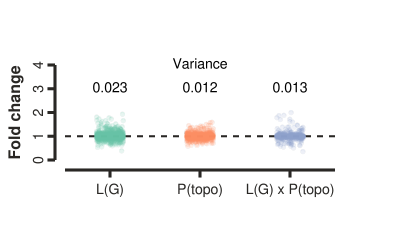

In [250]:
plot_bias(arr[:, :, 0, 0])

In [251]:
toyplot.config.autorender = False
for nspecies in (1, 2, 8):
    arr = np.load(f"./bias_full_{nspecies}pops.npy")
    for nidx, neff in enumerate([50_000, 100_000, 500_000]):
        for nsa, nsamples in enumerate([1, 2, 4]):
            canvas = plot_bias(arr[:, :, nidx, nsa])
            #toyplot.png.render(
            #    canvas, 
            #    f"../manuscript/figures/alternatives/bias-neff{neff}-nsamples{nsamples}-{nspecies}pops.png")